In [37]:
import random

juegos = ['Valorant','Fornite','DotA','Genshin']

pos = [i for i in range(len(juegos))]
listas = [0 for _ in range(len(juegos))]


for i in range(100):
    listas[random.choice(pos)] +=1 

winners = {juegos[i]: listas[i] for i in range(len(juegos))}
winners = dict(sorted(winners.items(), key=lambda item: item[1], reverse=True))
print(winners)

{'Valorant': 31, 'DotA': 25, 'Fornite': 23, 'Genshin': 21}


In [34]:
"""
from netCDF4 import Dataset, num2date
import cartopy.crs as ccrs
import cartopy.feature as cf
"""

from sklearn.metrics import ConfusionMatrixDisplay
#from sklearn.utils import shuffle
#from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pandas as pd
#import re
import numpy as np
import glob
import time
import os

In [16]:
"""
DEFINIMOS EL PATH BASE DEL PROYECTO
"""
path_base = 'C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/GPUTesis'

In [17]:
def crearDir(path, newDir):
    try:
        pathT = os.path.join(path, newDir)
        os.mkdir(pathT)
        return pathT
    except FileExistsError:
        return pathT
        pass
    except:
        print(f"No se pudo crear el directorio: {newDir}")
        pritn(f'Path base: {path}')
        pritn(f'Nuevo    : {newDir}')        
        return None

In [18]:
def writeExcel(file_out, infoDF, statDF):    
    writer = pd.ExcelWriter(file_out, engine = 'xlsxwriter')       
    infoDF.to_excel(writer, sheet_name = 'Informacion', index=False)
    for idModel, data in statDF.items():
        data.to_excel(writer, sheet_name = f'{idModel}', index=False)

    writer.save()    

In [19]:
def savetoFile(path_base,tipo, infoDf, statDF):
    path_out = crearDir(f'{path_base}/Archivos/Modelos', tipo)
    
    
    # Tests con 1 input
    head1 = infoDf[infoDf['inputs']=="['imagen']"] 
    if not head1.empty:
        data1 = {k: v for k, v in statDF.items() if k in head1['ModelID'].unique()}
        file_out1 = f'{path_out}/Stats_{tipo}-1_202204.xlsx'
        writeExcel(file_out1, head1, data1)
    
    # Test con 2 inputs
    head2 = infoDf[infoDf['inputs']=="['imagen', '99%']"] 
    if not head2.empty:
        data2 = {k: v for k, v in statDF.items() if k in head2['ModelID'].unique()}
        file_out2 = f'{path_out}/Stats_{tipo}-2_202204.xlsx'
        writeExcel(file_out2, head2, data2)
    
    # Test con 3 inputs
    head3 = infoDf[infoDf['inputs']=="['imagen', '99%', 'altura']"] 
    if not head3.empty:
        data3 = {k: v for k, v in statDF.items() if k in head3['ModelID'].unique()}
        file_out3 = f'{path_out}/Stats_{tipo}-3_202204.xlsx'
        writeExcel(file_out3, head3, data3)
    
    return path_out

In [20]:
def mergeFileStats(listFiles,path_base,tipo='Umbral'):
    infoDF = []
    statDF = {}
    for file in listFiles:
        headDF = pd.read_excel(file,nrows=1)
        headDF = headDF.dropna(axis='columns', how ='all')
        
        dataDF = pd.read_excel(file,skiprows=5)
        dataDF = dataDF.dropna(axis='columns', how ='all')
        
        headDF['best_val_acc'] = dataDF['val_acc'].max()
        infoDF.append(headDF)
        statDF[headDF['ModelID'][0]] = dataDF
    
    infoDF = pd.concat(infoDF)
    
    statFiles =  savetoFile(path_base,tipo, infoDF, statDF)
       
    
    return statFiles    

In [21]:
def selectTipoStats(df,tipo,ascending=False):
    dfT = df.sort_values(by=tipo, ascending=ascending).head(1)
    dfT['TIPO'] = tipo
    return dfT

In [22]:
def getDSStats(path_base,modelList,dsListT):
    print(f'\nESTADISTICAS DE LOS DATASETS')
    print('____________________________________')
    dsStats = {
        'idModel': [],
        'dsName' : [],
        'count'  : [],
        'mean'   : [],
        'std'    : [],
        'ceros'  : [],
        '_0-1'   : [],
        '_1-N'   : [],
        'max'    : [],
    }    
    
    list_set = set(dsListT)    
    dsList = (list(list_set))
    
    for i in range(len(dsList)):        
        dfDS = pd.read_csv(f'{dsList[i]}.csv')  
        print(f"DATASET {dsList[i].split('/')[-1]} SIN CEROS")
        print(f'Cantidad total: {dfDS["dato"].count()}')
        print(f'Cantidad ceros: {dfDS[dfDS["dato"]==0]["dato"].count()}')
        plt.hist(dfDS[dfDS['dato']!=0]['dato'])      
        plt.show()
        dsStats['idModel'].append(modelList[i]) 
        dsStats['dsName'].append(dsList[i].split('/')[-1]) 
        dsStats['count'].append(dfDS['dato'].count()) 
        dsStats['mean'].append(dfDS['dato'].mean()) 
        dsStats['std'].append(dfDS['dato'].std()) 
        dsStats['ceros'].append(dfDS[dfDS['dato']==0]['dato'].count()) 
        dsStats['_0-1'].append(dfDS[(dfDS['dato']>0) & (dfDS['dato']<=1)]['dato'].count()) 
        dsStats['_1-N'].append(dfDS[dfDS['dato']>1]['dato'].count()) 
        dsStats['max'].append(dfDS['dato'].max())      
        
        print(dsStats)
        print('---------------------------------------------------------')
    return pd.DataFrame(dsStats)

In [23]:
def summaryStats(path_base,stats_dir, params):
    
    os.chdir(stats_dir)
    listFiles = list(glob.glob('**/**/*.xlsx'))
    print(f'Cantidad de archivos encontrados: {len(listFiles)}')    
    
    columns = ['dsDir','idModel','HP','DS_len','dsName','epoca','val_TN','val_TP','val_FP',
               'val_FN','val_acc','TNR','TPR','PPV','NPV','F1']    
    results = pd.DataFrame(columns=columns)
    
    for file in listFiles:
        excelTemp = pd.read_excel(file, sheet_name=None)
        dsDir = excelTemp['Informacion']['dsDir'][0]
        dsName = file.split('Stats')[0][:-1]
        
        
        for k,v in excelTemp.items():
            if k != 'Informacion':
                dfTemp = excelTemp[k]             
                dfTemp['epoca'] = dfTemp['Unnamed: 0']
                dfTemp['DS_len'] = dfTemp['val_TN'] + dfTemp['val_TP'] + dfTemp['val_FP'] + dfTemp['val_FN']
                dfTemp['TNR'] = dfTemp['val_TN'] / (dfTemp['val_TN']+dfTemp['val_FP'])
                dfTemp['TPR'] = dfTemp['val_TP'] / (dfTemp['val_TP']+dfTemp['val_FN'])
                dfTemp['PPV']  = dfTemp['val_TP'] / (dfTemp['val_TP']+dfTemp['val_FP'])
                dfTemp['NPV'] = dfTemp['val_TN'] / (dfTemp['val_TN']+dfTemp['val_FN'])        
                dfTemp['F1'] = 2*(dfTemp['PPV'] * dfTemp['TPR']) / (dfTemp['PPV'] + dfTemp['TPR'])        

                dfTemp['idModel'] = k.split('-')[-1]
                dfTemp['HP'] = k.split('(')[1].split(')')[0].replace('-','_')
                dfTemp['dsDir'] = dsDir.replace('Splitted','Clasificacion')
                dfTemp['dsName'] = dsName
                                
                results = pd.concat([results,dfTemp[columns]],axis=0)
                
    print(f'Cantidad de datos: {len(results)}')
    print('---------------------------------------------------------')
    
    bestResults,modelList,dsList = getMatConfusion(results,params)
    
    print('---------------------------------------------------------')
    dsStats = getDSStats(path_base,modelList,dsList)    
    results.to_csv(f'{path_base}/Archivos/Reportes/Entrenamiento/Clasificacion/Reporte-Clasificacion.csv')
    
    return bestResults,results,dsStats

In [30]:
def getMatConfusion(df,p):       
    data = df
    
    print(f'\nRESUMEN DE ESTADISTICAS TOP  {p["top"]}')
    print(f'Criterio {p["criterio"]}')
    
    bestResults = []
    modelList = []
    dsList = []
    for i in range(p['top']):
        data = data.sort_values(p['criterio'], ascending=p['ascending'])
        modelList.append(data['idModel'].iloc[0])
        bestResults.append(data.iloc[0])
        dsList.append(data['dsDir'].iloc[0] + data['dsName'].iloc[0])
        
        print(f'\nMatriz Confusion : N°: {i+1} -- {data["idModel"].iloc[0]} -- {data["dsName"].iloc[0]} -- HP: {data["HP"].iloc[0]} -- {p["criterio"]}: {data[p["criterio"]].iloc[0]}')
        print(f'Dataset de tamaño: {data["DS_len"].iloc[0]}')
              
        cm = [[data['val_TP'].iloc[i],data['val_FN'].iloc[0]],
              [data['val_FP'].iloc[i],data['val_TN'].iloc[0]]]        

        disp = ConfusionMatrixDisplay(confusion_matrix=np.array(cm),
                               display_labels=['M02','C02'])
        disp.plot()
        plt.show()         
        
        data = data[data['idModel']!=data['idModel'].iloc[0]]
        
        
    print('---------------------------------------------------------')
    print(f'\nCOMPARACION RESULTADOS')    
        
    for comp in p['compare']:
        print(f'\nCOMPARACION :  {comp}\n')
        for idModel in modelList:
            dfModel = df[df['idModel']==idModel]
            plt.plot(dfModel['epoca'],dfModel[comp],label=idModel)
            plt.xlabel('EPOCAS')

            plt.title(f'Comparacion de : {comp}')
            plt.legend()

        plt.show()
     
    return bestResults,modelList, dsList
    

Cantidad de archivos encontrados: 27
Cantidad de datos: 1406
---------------------------------------------------------

RESUMEN DE ESTADISTICAS TOP  15
Criterio F1

Matriz Confusion : N°: 1 -- 20220427_151059 -- TesisDiego3D\CLASE_TrainDS_17 -- HP: 3_4_30 -- F1: 0.9623393885688968
Dataset de tamaño: 2161


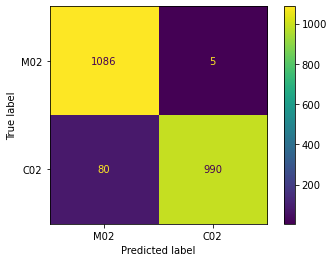


Matriz Confusion : N°: 2 -- 20220427_163912 -- TesisDiego3D\CLASE_TrainDS_17 -- HP: 3_4_40 -- F1: 0.9608791208791209
Dataset de tamaño: 2161


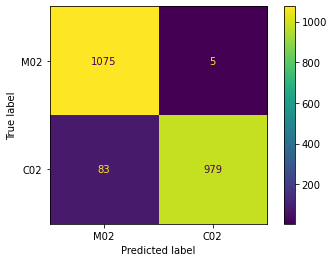


Matriz Confusion : N°: 3 -- 20220427_170659 -- TesisDiego3D\CLASE_TrainDS_17 -- HP: 2_4_40 -- F1: 0.9606791778373548
Dataset de tamaño: 2161


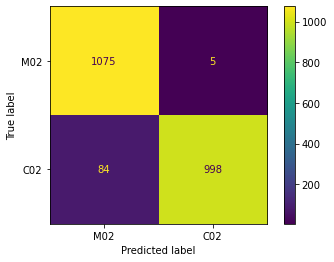


Matriz Confusion : N°: 4 -- 20220427_153315 -- TesisDiego3D\CLASE_TrainDS_17 -- HP: 2_4_30 -- F1: 0.9601433049708912
Dataset de tamaño: 2161


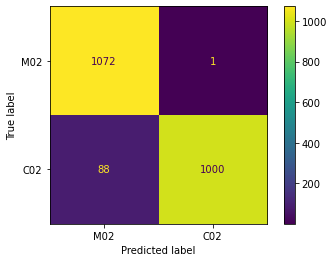


Matriz Confusion : N°: 5 -- 20220427_155941 -- TesisDiego3D\CLASE_TrainDS_17 -- HP: 3_3_30 -- F1: 0.9591926283457657
Dataset de tamaño: 2161


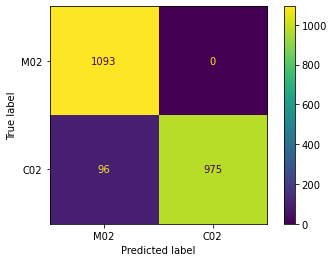


Matriz Confusion : N°: 6 -- 20220427_162118 -- TesisDiego3D\CLASE_TrainDS_17 -- HP: 2_3_40 -- F1: 0.9585746102449889
Dataset de tamaño: 2161


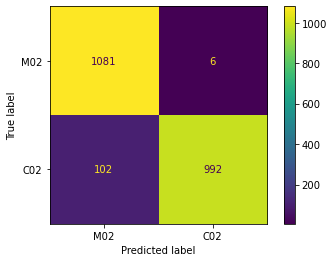


Matriz Confusion : N°: 7 -- 20220424_190243 -- TesisDiego\CLASE_TrainDS_0 -- HP: 3_6_30 -- F1: 0.8300704776820674
Dataset de tamaño: 2161


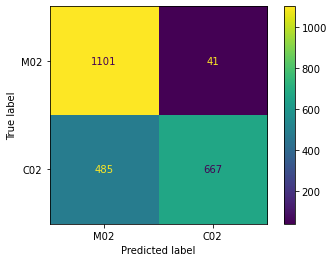


Matriz Confusion : N°: 8 -- 20220427_113849 -- TesisDiego3D\CLASE_TrainDS_15 -- HP: 2_3_40 -- F1: 0.8213614140654382
Dataset de tamaño: 2161


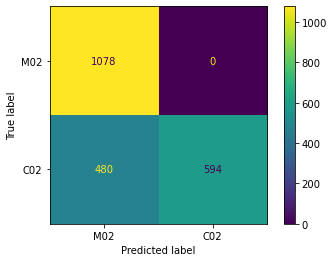


Matriz Confusion : N°: 9 -- 20220427_093841 -- TesisDiego3D\CLASE_TrainDS_14 -- HP: 3_4_40 -- F1: 0.8211077844311377
Dataset de tamaño: 2161


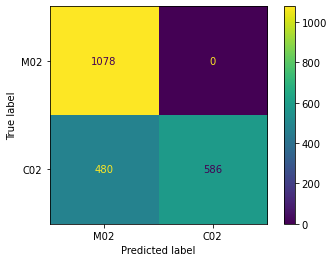


Matriz Confusion : N°: 10 -- 20220426_105504 -- TesisDiego\CLASE_TrainDS_15 -- HP: 2_6_30 -- F1: 0.8192497158014399
Dataset de tamaño: 2161


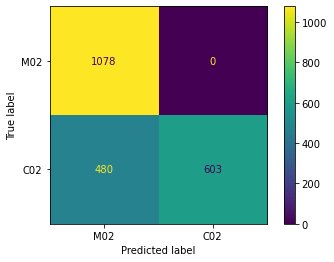


Matriz Confusion : N°: 11 -- 20220425_232358 -- TesisDiego\CLASE_TrainDS_14 -- HP: 3_6_30 -- F1: 0.8189096454441479
Dataset de tamaño: 2161


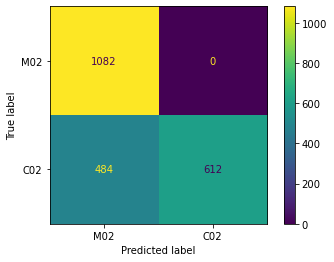


Matriz Confusion : N°: 12 -- 20220424_194306 -- TesisDiego\CLASE_TrainDS_0 -- HP: 2_6_30 -- F1: 0.8179059180576631
Dataset de tamaño: 2161


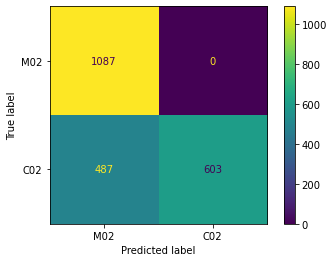


Matriz Confusion : N°: 13 -- 20220427_015610 -- TesisDiego3D\CLASE_TrainDS_11 -- HP: 3_4_30 -- F1: 0.8172932330827067
Dataset de tamaño: 2161


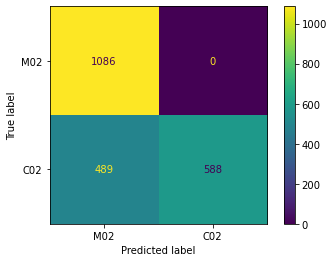


Matriz Confusion : N°: 14 -- 20220427_004613 -- TesisDiego3D\CLASE_TrainDS_10 -- HP: 2_3_40 -- F1: 0.8172205438066465
Dataset de tamaño: 2161


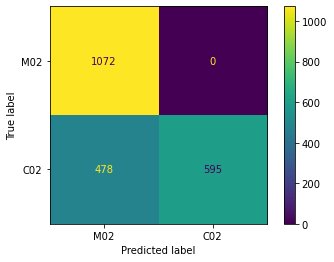


Matriz Confusion : N°: 15 -- 20220427_120530 -- TesisDiego3D\CLASE_TrainDS_15 -- HP: 3_4_40 -- F1: 0.817188088955899
Dataset de tamaño: 2161


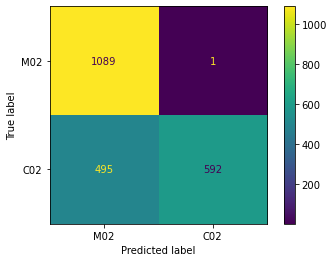

---------------------------------------------------------

COMPARACION RESULTADOS

COMPARACION :  val_acc



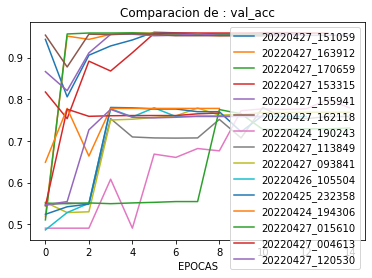

---------------------------------------------------------

ESTADISTICAS DE LOS DATASETS
____________________________________
DATASET TesisDiego3D\CLASE_TrainDS_17 SIN CEROS
Cantidad total: 2702
Cantidad ceros: 614


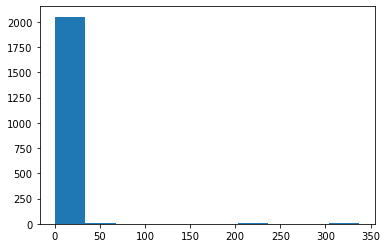

{'idModel': ['20220427_151059'], 'dsName': ['TesisDiego3D\\CLASE_TrainDS_17'], 'count': [2702], 'mean': [4.778449296817172], 'std': [26.44438847370925], 'ceros': [614], '_0-1': [594], '_1-N': [1494], 'max': [337.5]}
---------------------------------------------------------
DATASET TesisDiego3D\CLASE_TrainDS_15 SIN CEROS
Cantidad total: 2702
Cantidad ceros: 614


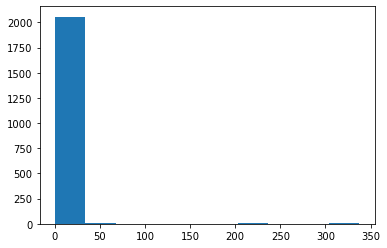

{'idModel': ['20220427_151059', '20220427_163912'], 'dsName': ['TesisDiego3D\\CLASE_TrainDS_17', 'TesisDiego3D\\CLASE_TrainDS_15'], 'count': [2702, 2702], 'mean': [4.778449296817172, 3.0953700962250186], 'std': [26.44438847370925, 26.381669154452883], 'ceros': [614, 614], '_0-1': [594, 1945], '_1-N': [1494, 143], 'max': [337.5, 337.5]}
---------------------------------------------------------


FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/GPUTesis/Archivos/Dataset/ClasificacionV2/TesisDiego\\CLASE_TrainDS_15.csv'

In [31]:
#metricas =  ['val_TN','val_TP','val_FP','val_FN','val_acc','TNR','TPR','PPV','NPV','F1']  

params = {    
    'top'      : 15,
    'criterio' : 'F1',         
    'ascending': False, # False =  mayor a menor      
        
    'compare'  : ['val_acc'],    
}

stats_dir = f'{path_base}/Archivos/Modelos/Clasificacion/'#TesisDiego3D_V3/'
bestResultados ,resultados, listaModel = summaryStats(path_base,stats_dir, params)

In [ ]:
resultados['dsName'].unique()

In [ ]:
pd.DataFrame(bestResultados)

In [27]:
os.chdir(stats_dir)
listFiles = list(glob.glob('**/**/*.xlsx'))
print(f'Cantidad de archivos encontrados: {len(listFiles)}')   
listFiles

Cantidad de archivos encontrados: 27


['TesisDiego\\CLASE_TrainDS_0\\Stats_clasificacion_clase_202204.xlsx',
 'TesisDiego\\CLASE_TrainDS_1\\Stats_clasificacion_clase_202204.xlsx',
 'TesisDiego\\CLASE_TrainDS_10\\Stats_clasificacion_clase_202204.xlsx',
 'TesisDiego\\CLASE_TrainDS_11\\Stats_clasificacion_clase_202204.xlsx',
 'TesisDiego\\CLASE_TrainDS_12\\Stats_clasificacion_clase_202204.xlsx',
 'TesisDiego\\CLASE_TrainDS_13\\Stats_clasificacion_clase_202204.xlsx',
 'TesisDiego\\CLASE_TrainDS_14\\Stats_clasificacion_clase_202204.xlsx',
 'TesisDiego\\CLASE_TrainDS_15\\Stats_clasificacion_clase_202204.xlsx',
 'TesisDiego3D\\CLASE_TrainDS_0\\Stats_clasificacion_clase_202204.xlsx',
 'TesisDiego3D\\CLASE_TrainDS_1\\Stats_clasificacion_clase_202204.xlsx',
 'TesisDiego3D\\CLASE_TrainDS_10\\Stats_clasificacion_clase_202204.xlsx',
 'TesisDiego3D\\CLASE_TrainDS_11\\Stats_clasificacion_clase_202204.xlsx',
 'TesisDiego3D\\CLASE_TrainDS_12\\Stats_clasificacion_clase_202204.xlsx',
 'TesisDiego3D\\CLASE_TrainDS_13\\Stats_clasificacion_clas